In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_io as tfio


import joblib

import librosa
import librosa.display

In [3]:
BASE_PATH = '../data/G2Net/g2net-gravitational-wave-detection/'

train = pd.read_csv(BASE_PATH + 'training_labels.csv')
test = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [4]:
def npy_header_offset(npy_path):
    with open(str(npy_path), 'rb') as f:
        if f.read(6) != b'\x93NUMPY':
            raise ValueError('Invalid NPY file.')
        version_major, version_minor = f.read(2)
        if version_major == 1:
            header_len_size = 2
        elif version_major == 2:
            header_len_size = 4
        else:
            raise ValueError('Unknown NPY file version {}.{}.'.format(version_major, version_minor))
        header_len = sum(b << (8 * i) for i, b in enumerate(f.read(header_len_size)))
        header = f.read(header_len)
        if not header.endswith(b'\n'):
            raise ValueError('Invalid NPY file.')
        return f.tell()

# Dataset filepath handling
def apply_raw_path(row, is_train=True): 
    file_name = row[0]
    if is_train:
        return os.path.join(
            BASE_PATH, 'train',
            file_name[0],
            file_name[1],
            file_name[2],
            file_name + ".npy")
    else:
        return os.path.join(
            BASE_PATH, 'test',
            file_name[0],
            file_name[1],
            file_name[2],
            file_name + ".npy")

# local traitement filepath hgandling
def get_train_file_path(image_id):
    return BASE_PATH + "train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return BASE_PATH + "test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)


In [5]:
df = pd.read_csv(os.path.join(BASE_PATH, 'training_labels.csv'))

In [6]:
df['file_path'] = df.apply(apply_raw_path, args=(True,), axis=1)
df['target'] = df['target'].astype('float32')
df.head()

,id,target,file_path
0,00000e74ad,1.0,../data/G2Net/g2net-gravitational-wave-detecti...
1,00001f4945,0.0,../data/G2Net/g2net-gravitational-wave-detecti...
2,0000661522,0.0,../data/G2Net/g2net-gravitational-wave-detecti...
3,00007a006a,0.0,../data/G2Net/g2net-gravitational-wave-detecti...
4,0000a38978,1.0,../data/G2Net/g2net-gravitational-wave-detecti...


# Dataset sandbox

In [7]:
def raw_ingest(data):
    data = tf.reshape(tf.io.decode_raw(data, tf.float64), (3,4096))
    data = tf.cast(data, tf.float32)
    return data

ds_label = tf.data.Dataset.from_tensor_slices(df['target'])
ds_raw_data = tf.data.FixedLengthRecordDataset(
    df['file_path'],
    98304,
    header_bytes=128,
    num_parallel_reads=4).map(lambda data: raw_ingest(data))
ds_raw = tf.data.Dataset.zip((ds_raw_data, ds_label))  

In [8]:
for data in ds_raw_data.take(2):
    print(data)

tf.Tensor(
[[-5.9483055e-21 -5.8499546e-21 -5.4241516e-21 ... -6.0669897e-21
  -5.9634572e-21 -5.7577845e-21]
 [ 9.7540710e-22  4.5258614e-22  4.5864389e-23 ... -1.0960821e-20
  -1.0976663e-20 -1.1085813e-20]
 [-1.7487198e-21 -1.1828679e-21 -1.9322378e-21 ...  1.4650227e-21
   2.1864486e-21  1.5408594e-21]], shape=(3, 4096), dtype=float32)
tf.Tensor(
[[-1.2655740e-21 -9.9823595e-22 -1.1198638e-21 ... -8.5021434e-22
  -1.1164120e-21 -1.0775731e-21]
 [ 5.5544052e-22  2.2185540e-22 -3.8979531e-22 ...  1.1492604e-21
   1.0929125e-21  8.1230434e-22]
 [-1.4536855e-21 -1.0384230e-21 -1.3568949e-21 ...  4.3694417e-22
   4.4232539e-22  8.5153226e-22]], shape=(3, 4096), dtype=float32)


In [16]:
import torch
from nnAudio.Spectrogram import CQT1992v2

transform=CQT1992v2(sr=2048, fmin=22, fmax=512, hop_length=64)

def cqt_2_rgb(data): # in order to use efficientnet we need 3 dimension images
    
    data = data.numpy()
    
    wave0 = np.concatenate((data[0], data[0]))
    wave1 = np.concatenate((data[1], data[1]))
    wave2 = np.concatenate((data[2], data[2]))
    
    wave0 = transform(torch.from_numpy(wave0))
    wave1 = transform(torch.from_numpy(wave1))
    wave2 = transform(torch.from_numpy(wave2))
    image = tf.convert_to_tensor([
        np.array(wave0)[0],
        np.array(wave1)[0],
        np.array(wave2)[0]])
    image = tf.transpose(image,(1,2,0))
    return image

def wave_transform(data):
    data = tf.reshape(tf.io.decode_raw(data, tf.float64), (3,4096))
    data = tf.cast(data, tf.float32)

    data0 = data[0]/data[0][tf.argmax(data[0])]
    data1 = data[1]/data[1][tf.argmax(data[1])]
    data2 = data[2]/data[2][tf.argmax(data[2])]
    data = tf.stack([data0, data1, data2])
    
    data = tf.py_function(
            cqt_2_rgb,
            [data],
            [tf.float32])
    
    data = tf.convert_to_tensor(data[0])
    data = tf.math.minimum(data, .99)
#     data.set_shape([42,129,3])
#     data = data/7
#     data = (tfio.audio.dbscale(data, 80)+95)/100

    return data

ds_label = tf.data.Dataset.from_tensor_slices(df['target'])
ds_data = tf.data.FixedLengthRecordDataset(
    df['file_path'],
    98304,
    header_bytes=128,
    num_parallel_reads=4).map(wave_transform)
ds = tf.data.Dataset.zip((ds_data, ds_label))

CQT kernels created, time used = 0.0150 seconds


In [17]:
min_value = 1
max_value = 0
for data in ds_data.take(100):
#     data = (tfio.audio.dbscale(data, 40))
    local_max = np.amax(data.numpy())
    if  local_max > max_value:
        max_value = local_max 
    local_min = np.amin(data.numpy())
    if  local_min < min_value:
        min_value = local_min 

print(ds.cardinality)
print("Min value: ", min_value)
print("Max value: ", max_value)
print(data)

<bound method DatasetV2.cardinality of <ZipDataset shapes: (<unknown>, ()), types: (tf.float32, tf.float32)>>
Min value:  3.7332043e-06
Max value:  0.99
tf.Tensor(
[[[3.79254341e-01 1.90391198e-01 9.90000010e-01]
  [3.90513092e-01 1.79462954e-01 9.90000010e-01]
  [3.74610722e-01 1.75620750e-01 9.90000010e-01]
  ...
  [2.61859596e-01 3.31546158e-01 2.52039790e-01]
  [2.87773848e-01 3.51130277e-01 1.79090366e-01]
  [2.99734414e-01 3.58028948e-01 1.46891475e-01]]

 [[4.01907146e-01 1.22573599e-01 9.90000010e-01]
  [3.96426857e-01 1.10409476e-01 9.90000010e-01]
  [3.70771617e-01 1.06883973e-01 9.90000010e-01]
  ...
  [2.31549367e-01 3.14548016e-01 3.85757595e-01]
  [2.35514149e-01 3.35918903e-01 2.99508989e-01]
  [2.35885724e-01 3.44473928e-01 2.64760554e-01]]

 [[4.07896578e-01 6.29403517e-02 9.90000010e-01]
  [3.88311565e-01 6.70880675e-02 9.90000010e-01]
  [3.71120840e-01 5.63468635e-02 9.90000010e-01]
  ...
  [2.17520162e-01 3.01798463e-01 3.20650727e-01]
  [2.27459937e-01 3.16362709e-

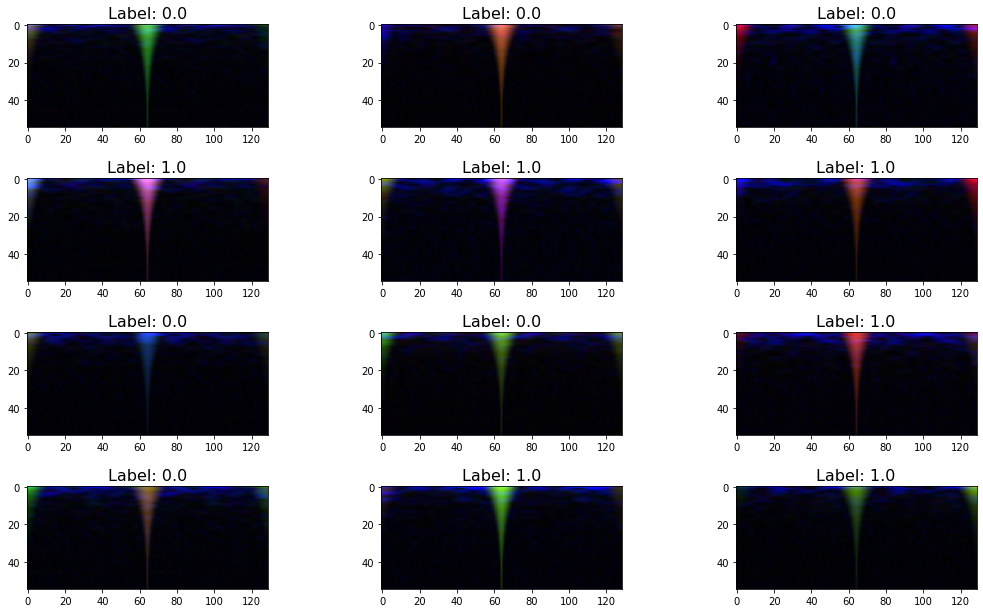

Min value:  1
Max value:  0


In [18]:
fig,a =  plt.subplots(4,3, figsize=(18,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)
cpt = 0
min_value = 1
max_value = 0
for data, label in ds.skip(30).take(12):
    tfio.audio.dbscale(data, 40)
    line = cpt % 3
    col = cpt // 3
    a[col, line].imshow(data)
    a[col, line].set_title(
            'Label: ' + str(label.numpy()),
            fontsize=16)
    cpt = cpt + 1

plt.show()
print("Min value: ", min_value)
print("Max value: ", max_value)


# Initial data analysis

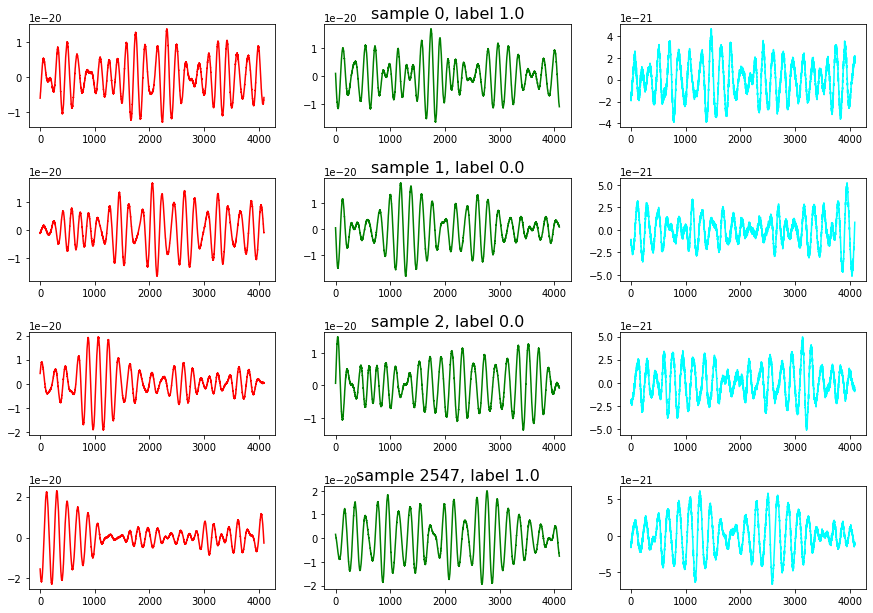

(3, 4096)

In [6]:
sample_num = 2579

def plot_samples(sample_list):
    fig,a =  plt.subplots(len(sample_list), 3, figsize=(15,2 * len(sample_list)))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)
    cpt = 0
    for sample_num in sample_list:
        sample = np.load(df.loc[sample_num]['file_path'])
        a[cpt, 0].plot(sample[0],color='red')
        a[cpt, 1].plot(sample[1],color='green')
        a[cpt, 2].plot(sample[2],color='cyan')
        a[cpt, 1].set_title(
            'sample ' + str(sample_num) +
            ', label ' + str(df.loc[sample_num]['target']),
            fontsize=16
        )
        cpt = cpt + 1
    plt.savefig('./images/base_samples.jpg', bbox_inches='tight')
    plt.show()
    
    return sample.shape

samples = [0, 1, 2, 2547]
plot_samples(samples)


In [8]:
print("Sample shape: ",str(np.load(df.loc[2547]['file_path']).shape))
print("Number of records:", str(len(df)))

Sample shape:  (3, 4096)
Number of records: 560000


In [9]:
def to_melspec(file_path):
    waves = np.load(file_path).astype(np.float32) # (3, 4096)
    melspecs = []
    for j in range(3):
        melspec = librosa.feature.melspectrogram(waves[j] / max(waves[j]),
                                                 sr=4096, n_mels=128, fmin=10, fmax=200)
        melspec = librosa.power_to_db(melspec)
        melspec = melspec.transpose((1, 0))
        melspecs.append(melspec)
    image = np.vstack(melspecs)
    return image

def plot(idx):
    data = np.load(df.loc[idx]['file_path'])
    print(df.loc[idx]['file_path'])
    fig,a =  plt.subplots(4,1, figsize=(12,12))
    a[0].plot(data[0],color='green')
    a[1].plot(data[1],color='red')
    a[2].plot(data[2],color='yellow')
    melspec_data = to_melspec(df.loc[idx]['file_path'])
    a[3].imshow(melspec_data)
    fig.suptitle('Plotting : ' + str(idx), fontsize=16)
    plt.show()


In [9]:
data = to_melspec(df.loc[0]['file_path'])
print(data.shape)
print(data)

(27, 128)
[[ 23.659393    24.01002     24.88653    ... -27.682549   -31.556004
  -32.549255  ]
 [ 17.510027    17.892597    18.802658   ... -26.028814   -26.897438
  -27.240623  ]
 [-22.787561   -17.357637   -14.101559   ... -16.943796   -14.635239
  -13.2507305 ]
 ...
 [-20.125336   -14.849211   -11.622976   ...  -5.2058797   -4.394677
   -3.5915864 ]
 [  2.244716     1.068778    -0.61750895 ...  -1.6967077   -1.6385005
   -1.2593315 ]
 [  6.7462187    6.3898153    6.3667154  ...  -2.1508906   -6.113221
  -23.064384  ]]


../data/G2Net/g2net-gravitational-wave-detection/train\0\0\0\00000e74ad.npy


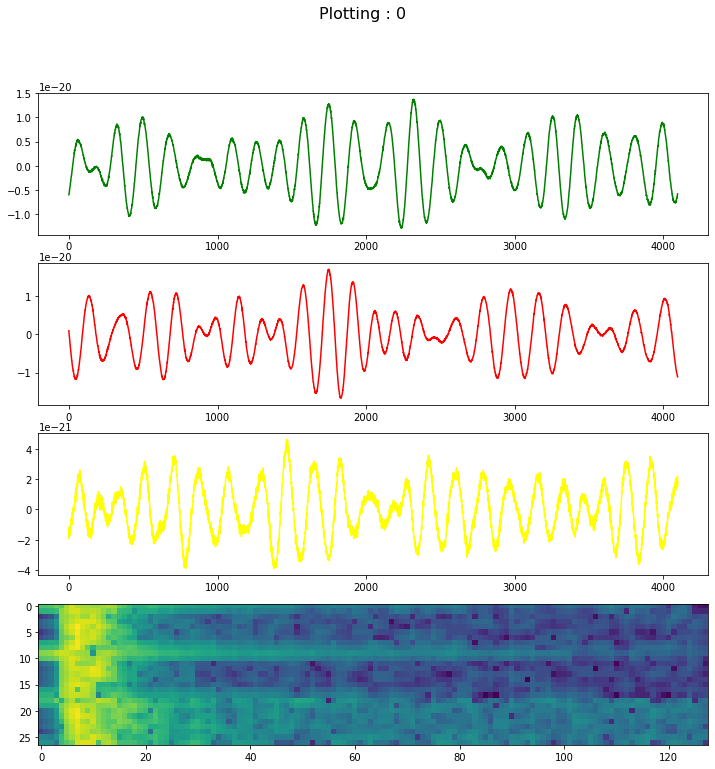

In [10]:
plot(0)

# raw data analysis
I know this is ugly 

In [10]:
def raw_ingest(data):
    data = tf.reshape(tf.io.decode_raw(data, tf.float64), (3,4096))
    data = tf.cast(data, tf.float32)
    data = tf.transpose(data)
    return data

ds_label = tf.data.Dataset.from_tensor_slices(df['target'])
ds_raw_data = tf.data.FixedLengthRecordDataset(
    df['file_path'],
    98304,
    header_bytes=128,
    num_parallel_reads=4).map(lambda data: raw_ingest(data))
ds_raw = tf.data.Dataset.zip((ds_raw_data, ds_label))  

In [11]:
df_stats_0 = pd.DataFrame()
df_stats_1 = pd.DataFrame()
df_stats_2 = pd.DataFrame()

# for data, label in  ds_raw.take(10000):
for data, label in  ds_raw.take(100):
    df_buf = pd.DataFrame(data.numpy()).describe()
    df_stats_0 = df_stats_0.append([[df_buf.loc['mean'][0], df_buf.loc['std'][0], df_buf.loc['min'][0], df_buf.loc['max'][0]]])
    df_stats_1 = df_stats_1.append([[df_buf.loc['mean'][1], df_buf.loc['std'][1], df_buf.loc['min'][1], df_buf.loc['max'][1]]])
    df_stats_2 = df_stats_2.append([[df_buf.loc['mean'][2], df_buf.loc['std'][2], df_buf.loc['min'][2], df_buf.loc['max'][2]]])

df_stats_0.columns=['mean', 'std', 'min', 'max']
df_stats_1.columns=['mean', 'std', 'min', 'max']
df_stats_2.columns=['mean', 'std', 'min', 'max']


In [12]:
#
df_stats_0.describe()

,mean,std,min,max
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-2.479271e-24,7.269105e-21,-1.823265e-20,1.820664e-20
std,6.700796e-23,1.498852e-21,3.592039e-21,3.785184e-21
min,-1.765635e-22,4.771026e-21,-2.883983e-20,1.068375e-20
25%,-5.315751e-23,6.188168e-21,-2.103593e-20,1.595511e-20
50%,3.992835e-24,7.222405e-21,-1.834344e-20,1.779705e-20
75%,3.884410e-23,8.111691e-21,-1.604240e-20,2.062788e-20
max,1.672767e-22,1.415502e-20,-1.061060e-20,3.534220e-20


In [13]:
df_stats_1.describe()

,mean,std,min,max
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-5.486033e-24,7.315387e-21,-1.831265e-20,1.829193e-20
std,6.934083e-23,1.695819e-21,4.314162e-21,4.169993e-21
min,-1.667430e-22,3.292909e-21,-2.918349e-20,9.283613e-21
25%,-5.213394e-23,6.102442e-21,-2.067641e-20,1.553837e-20
50%,-1.414654e-23,7.142181e-21,-1.788459e-20,1.829721e-20
75%,4.573020e-23,8.447528e-21,-1.549337e-20,2.049257e-20
max,1.864131e-22,1.262084e-20,-9.835085e-21,2.801213e-20


In [14]:
df_stats_2.describe()

,mean,std,min,max
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-1.703897e-24,1.805447e-21,-4.967428e-21,4.932352e-21
std,1.830387e-23,3.352944e-22,8.754072e-22,8.855845e-22
min,-5.756942e-23,1.148313e-21,-8.079410e-21,2.985636e-21
25%,-1.135305e-23,1.566968e-21,-5.466303e-21,4.346253e-21
50%,1.421580e-24,1.769718e-21,-4.871238e-21,4.849318e-21
75%,9.801803e-24,1.981699e-21,-4.369534e-21,5.525527e-21
max,4.549406e-23,2.957280e-21,-2.887370e-21,7.811783e-21


In [15]:
def raw_scale_ingest(data):
    data = tf.reshape(tf.io.decode_raw(data, tf.float64), (3,4096))
    data = tf.cast(data, tf.float32)
#     data = tf.transpose(data)
# #     data = tf.math.divide(data, tf.constant(([7.264676e-21, 7.215484e-21, 1.808104e-21])))
#     data = tf.math.divide(data, tf.constant(([3.767233e-20, 3.382723e-20, 9.739661e-21])))
    return data

ds_scale_data = tf.data.FixedLengthRecordDataset(
    df['file_path'],
    98304,
    header_bytes=128,
    num_parallel_reads=4).map(lambda data: raw_scale_ingest(data))
ds_scale = tf.data.Dataset.zip((ds_scale_data, ds_label))  

In [14]:

df_stats_0 = pd.DataFrame()
df_stats_1 = pd.DataFrame()
df_stats_2 = pd.DataFrame()

for data, label in  ds_scale.take(100):
    df_buf = pd.DataFrame(data.numpy()).describe()
    df_stats_0 = df_stats_0.append([[df_buf.loc['mean'][0], df_buf.loc['std'][0], df_buf.loc['min'][0], df_buf.loc['max'][0]]])
    df_stats_1 = df_stats_1.append([[df_buf.loc['mean'][1], df_buf.loc['std'][1], df_buf.loc['min'][1], df_buf.loc['max'][1]]])
    df_stats_2 = df_stats_2.append([[df_buf.loc['mean'][2], df_buf.loc['std'][2], df_buf.loc['min'][2], df_buf.loc['max'][2]]])

df_stats_0.columns=['mean', 'std', 'min', 'max']
df_stats_1.columns=['mean', 'std', 'min', 'max']
df_stats_2.columns=['mean', 'std', 'min', 'max']

In [15]:
#
df_stats_0.describe()

,mean,std,min,max
count,100.000000,100.000000,100.000000,100.000000
mean,-0.000066,0.192956,-0.483980,0.483290
std,0.001779,0.039787,0.095350,0.100477
min,-0.004687,0.126645,-0.765544,0.283597
25%,-0.001411,0.164262,-0.558392,0.423523
50%,0.000106,0.191716,-0.486921,0.472417
75%,0.001031,0.215322,-0.425840,0.547560
max,0.004440,0.375741,-0.281655,0.938148


In [235]:
#
df_stats_1.describe()

,mean,std,min,max
count,100.000000,100.000000,100.000000,100.000000
mean,-0.000760,1.013845,-2.537965,2.535094
std,0.009610,0.235025,0.597903,0.577923
min,-0.023109,0.456380,-4.044564,1.286624
25%,-0.007225,0.845741,-2.865561,2.153475
50%,-0.001961,0.989841,-2.478640,2.535825
75%,0.006338,1.170750,-2.147239,2.840082
max,0.025835,1.749134,-1.363053,3.882224


In [236]:
#
df_stats_2.describe()

,mean,std,min,max
count,100.000000,100.000000,100.000000,100.000000
mean,-0.000942,0.998526,-2.747313,2.727914
std,0.010123,0.185453,0.484158,0.489786
min,-0.031840,0.635172,-4.468443,1.651253
25%,-0.006279,0.866740,-3.023224,2.403763
50%,0.000786,0.978706,-2.694114,2.681991
75%,0.005421,1.096071,-2.416639,3.055979
max,0.025161,1.635626,-1.596905,4.320428


# Dataset transform

In [165]:
df_buf.loc['mean']

0   -4.629488e-23
1   -1.206258e-23
2   -1.560949e-23
Name: mean, dtype: float64

In [16]:
# numpy header length parser

    
# records chosen in train df indexes / raise error if was allocated to test df
for record_num in [0, 1, 3, 25, 2586, 54863, 258412, 559998]:
    file_length = os.path.getsize(df.loc[record_num]['file_path'])
    header_size = npy_header_offset(df.loc[record_num]['file_path'])
    print(
        "File length:", file_length,
        ", Header size: ",  header_size,
        ", Data length", file_length - header_size
    )

File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304
File length: 98432 , Header size:  128 , Data length 98304


In [ ]:
ds_data = tf.data.FixedLengthRecordDataset(
    df['file_path'],
    98304,
    header_bytes=128,
    num_parallel_reads=4).map(wave_transform)

In [19]:
import torch
from nnAudio.Spectrogram import CQT1992v2

transform=CQT1992v2(sr=2048, fmin=18, fmax=200, hop_length=64)

def cqt_2_rgb(image): # in order to use efficientnet we need 3 dimension images
    waves = image.numpy()
#     waves = np.hstack(waves)
    
    wave0 = np.concatenate((waves[0], waves[0]))
    wave1 = np.concatenate((waves[1], waves[1]))
    wave2 = np.concatenate((waves[2], waves[2]))

    wave0 = wave0 / np.max(wave0)
    wave1 = wave1 / np.max(wave1)
    wave2 = wave2 / np.max(wave2)
    
    #     waves = waves / np.max(waves)
    wave0 = torch.from_numpy(wave0).float()
    wave1 = torch.from_numpy(wave1).float()
    wave2 = torch.from_numpy(wave2).float()
    image0 = transform(wave0)
    image1 = transform(wave1)
    image2 = transform(wave2)
#     image = np.array(image)
#     image = np.transpose(image,(1,2,0))
    image = tf.convert_to_tensor([np.array(image0)[0], np.array(image1)[0], np.array(image2)[0]])
    image = tf.transpose(image,(1,2,0))
    return image

def wave_transform(data):
    data = tf.reshape(tf.io.decode_raw(data, tf.float64), (3,4096))
    data = tf.cast(data, tf.float32)
#     data = tf.transpose(data)
#     data = tf.math.divide(data, tf.constant(([7.264676e-21, 7.215484e-21, 1.808104e-21])))
# #     data = tf.math.divide(data, tf.constant(([3.767233e-20, 3.382723e-20, 9.739661e-21])))
#     data = tf.transpose(data)

    data = tf.py_function(
#             torch_increase_dimension,
            cqt_2_rgb,
            [data],
            [tf.float32])
    data = tf.convert_to_tensor(data)
    return data[0]


# Build validation

ds_label = tf.data.Dataset.from_tensor_slices(df['target'])
ds_data = tf.data.FixedLengthRecordDataset(
    df['file_path'],
    98304,
    header_bytes=128,
    num_parallel_reads=4).map(wave_transform)
ds = tf.data.Dataset.zip((ds_data, ds_label))


CQT kernels created, time used = 0.0100 seconds


In [21]:
min_value = 1
max_value = 0
for data, label in ds.take(1000):
#     data = tf.math.log(data)
    local_max = np.amax(data.numpy())
    if  local_max > max_value:
        max_value = local_max 
    local_min = np.amin(data.numpy())
    if  local_min < min_value:
        min_value = local_min 

print(ds.cardinality)
print("Min value: ", min_value)
print("Max value: ", max_value)
print(data)

<bound method DatasetV2.cardinality of <ZipDataset shapes: (<unknown>, ()), types: (tf.float32, tf.float32)>>
Min value:  1.0872998e-07
Max value:  5.233619
tf.Tensor(
[[[0.2197863  0.28915343 0.94864905]
  [0.21668947 0.28975296 0.9497288 ]
  [0.20012525 0.28643954 0.9497753 ]
  ...
  [0.62828577 0.69573385 0.333795  ]
  [0.6496906  0.71984404 0.28547823]
  [0.6554351  0.7274339  0.26612324]]

 [[0.1093149  0.2222114  1.0235051 ]
  [0.11187435 0.21591829 1.0173237 ]
  [0.1177261  0.20609437 0.9985569 ]
  ...
  [0.6551243  0.38529888 0.79326093]
  [0.6884607  0.40525568 0.7968172 ]
  [0.69881594 0.4168387  0.8058254 ]]

 [[0.01244516 0.1992606  0.512854  ]
  [0.01602329 0.19273698 0.50123614]
  [0.02385739 0.17949066 0.46887982]
  ...
  [0.6534693  0.36660522 1.0351847 ]
  [0.66515    0.38203892 1.0471332 ]
  [0.6696477  0.38730612 1.0511409 ]]

 ...

 [[0.00158616 0.00995549 0.00197681]
  [0.00402849 0.00853302 0.01865635]
  [0.01133506 0.00213427 0.05278198]
  ...
  [0.00325516 0.005

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

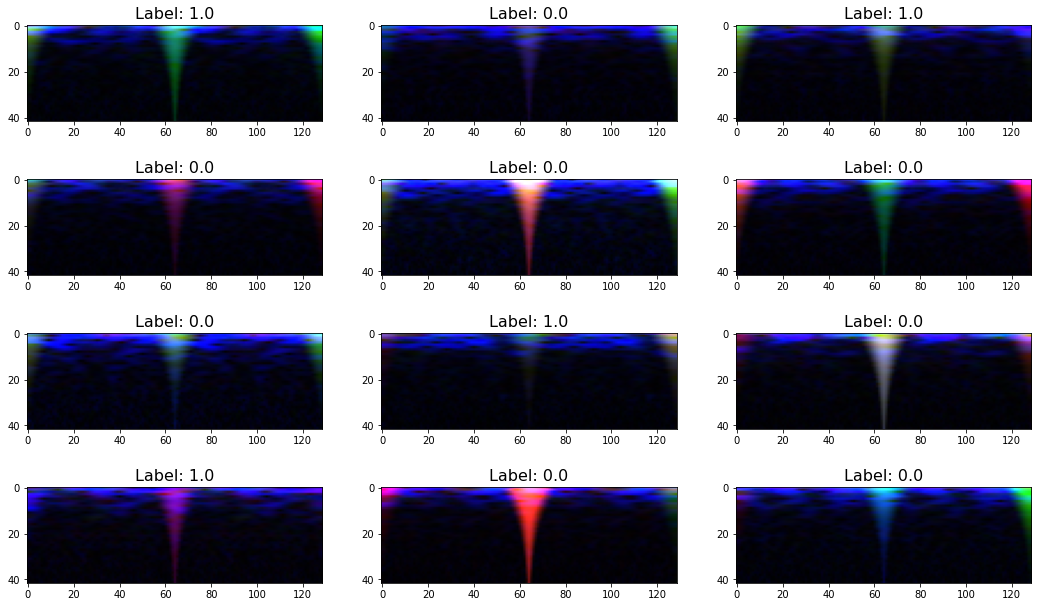

Min value:  1
Max value:  0


In [22]:
fig,a =  plt.subplots(4,3, figsize=(18,8))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)
cpt = 0
min_value = 1
max_value = 0
for data, label in ds.skip(15).take(12):
    line = cpt % 3
    col = cpt // 3
    a[col, line].imshow(data)
    a[col, line].set_title(
            'Label: ' + str(label.numpy()),
            fontsize=16)
    cpt = cpt + 1

plt.show()
print("Min value: ", min_value)
print("Max value: ", max_value)


In [117]:
print(ds.cardinality)

<bound method DatasetV2.cardinality of <ZipDataset shapes: ((32, 256, 3), ()), types: (tf.float32, tf.int8)>>


In [261]:
test.shape

(226000, 2)

# Initial and Dataset compare 

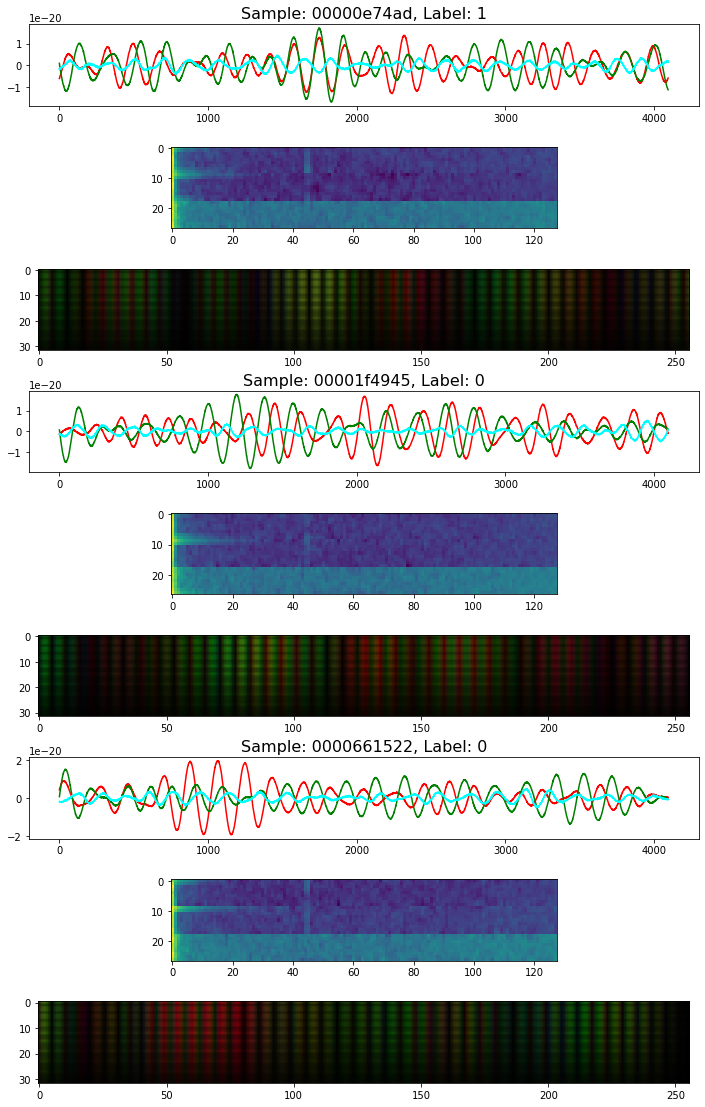

In [48]:
def plot_cmp(count):
    cpt = 0
    fig,a =  plt.subplots(count*3,1, figsize=(12,5*count))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)
    for ds_data, label in ds.take(count):
        data_path = df.loc[cpt]['file_path']
        data = np.load(data_path)
        a[cpt*3].set_title(
            "Sample: "+ str(train.loc[cpt]['id']) +
            ", Label: " + str(train.loc[cpt]['target']),
            fontsize=16)

        a[cpt*3].plot(data[0], color='red')
        a[cpt*3].plot(data[1], color='green')
        a[cpt*3].plot(data[2], color='cyan')

        a[cpt*3+1].imshow(to_melspec(data_path))
        
        a[cpt*3+2].imshow(ds_data.numpy())
#             print(data_ds.numpy().shape)
        cpt = cpt + 1

plot_cmp(3)